In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import ddm.plot
import matplotlib.pyplot as plt
import pandas as pd
import ddm.models
from itertools import product
from ddm import Sample, Model, Fittable, Solution
from ddm.functions import fit_adjust_model, display_model, fit_model, dependence_hit_boundary
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, LossRobustBIC, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
import os, sys 
from scipy import stats
from scipy.stats import zscore

In [2]:
df = pd.read_csv("/Users/terlau/LNDG/EyeMem/EyeMem_1/DDM/EyeMem_hddm_test.csv")
# Clean from Invalid Reaction Times 
data=df.loc[~df['rt'].isnull()]
print(data)
data['z_rt'] = stats.zscore(data['rt'])
data = data[np.abs(data['z_rt']) < 3]
#data = data[np.abs(data['rt']-data['rt'].mean()) <= (3*data['rt'].std())]
# keep only the ones that are within +3 to -3 standard deviations

#data['rt'] = data[data["rt"] < .25] # Remove trials less than 100ms
#data['rt'] = data[data["rt"] > 1.65] # Remove trials greater than 1650ms
SubjectList = np.unique(data['subj_idx'])
data

       subj_idx  category  stim  response  accuracy     rt  age
0             9         3     1       2.0         1  0.739    0
1             9         3     1       2.0         1  0.859    0
2             9         3     1       1.0         0  0.716    0
3             9         3     0       1.0         0  1.153    0
4             9         3     0       2.0         0  0.665    0
...         ...       ...   ...       ...       ...    ...  ...
26007       101         3     0       2.0         1  1.008    1
26008       101         3     1       1.0         1  0.838    1
26009       101         3     1       1.0         1  0.609    1
26010       101         3     0       1.0         0  0.712    1
26011       101         3     0       2.0         1  0.884    1

[25846 rows x 7 columns]


<ipython-input-2-051e8d81c7a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['z_rt'] = stats.zscore(data['rt'])


,subj_idx,category,stim,response,accuracy,rt,age,z_rt
0,9,3,1,2.0,1,0.739,0,-0.796713
1,9,3,1,2.0,1,0.859,0,-0.455187
2,9,3,1,1.0,0,0.716,0,-0.862172
3,9,3,0,1.0,0,1.153,0,0.381551
4,9,3,0,2.0,0,0.665,0,-1.007320
...,...,...,...,...,...,...,...,...
26007,101,3,0,2.0,1,1.008,1,-0.031126
26008,101,3,1,1.0,1,0.838,1,-0.514954
26009,101,3,1,1.0,1,0.609,1,-1.166699
26010,101,3,0,1.0,0,0.712,1,-0.873556


2.072
0.231
2.9970678791508854
-2.2425042957856283
[1. 2.]
age
0    1.057011
1    0.953713
Name: rt, dtype: float64
age
0    0.739870
1    0.672684
Name: accuracy, dtype: float64


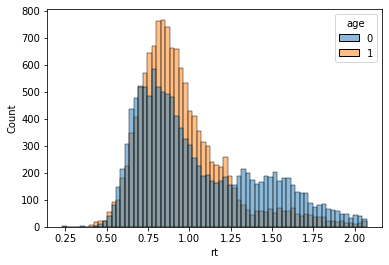

In [3]:
print(data['rt'].max())
print(data['rt'].min())
print(data['z_rt'].max())
print(data['z_rt'].min())
#data = data.dropna()
#data = data.reset_index(drop=True)
#print(data)
#data=data.loc[~data['response'].isnull()] # response has a lot of nan values only for study (around 800-900)
#data = data.reset_index(drop=True)
#print(data)
print(np.unique(data['response']))
df_age= data.groupby('age')
print(df_age['rt'].mean())
print(df_age['accuracy'].mean())
sns.histplot(data=data, x="rt", hue="age")
plt.show()


In [4]:
data.isnull().sum()

subj_idx    0
category    0
stim        0
response    0
accuracy    0
rt          0
age         0
z_rt        0
dtype: int64

In [ ]:
# very simple model - not possible to be fitted!
 
model = Model(name='Simple model',
              drift=DriftConstant(drift=2.2),
              noise=NoiseConstant(noise=1.5),
              bound=BoundConstant(B=1.1),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2.5)


In [8]:
def setup_model():
    """
    Function to setup model. 
    """
    model = Model(name='Simple model',
            drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
            noise=NoiseConstant(noise=Fittable(minval=.1, maxval=2)),
            #bound = BoundCollapsingExponential(B=Fittable(minval=0.5, maxval=3),tau=Fittable(minval=.0001,maxval=5)),
            bound=BoundConstant(B=Fittable(minval=0.1, maxval=1)),
            #IC=ICRange(sz=.2),
            overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.8)),
            dx=.01, dt=.05, T_dur=2.5)      
      
    return model


Analytic solutions are only possible in a select number of special cases; in particular, it works for simple DDM and for linearly collapsing bounds and arbitrary single-point initial conditions. (See Anderson (1960) for implementation details.) For most reasonably complex models, the method will fail. Check whether a solution is possible with has_analytic_solution()

mean decision time 0.7958405172413793
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7759197324414716 0.22408026755852842
0.0
True
True
Params [1.34609683 1.15694635 0.74988892 0.54865792] gave 87.52451030846504
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=87.52451030846504, nparams=4, samplesize=299, mess='')
9
correct RTs prob 0.8181950319992424


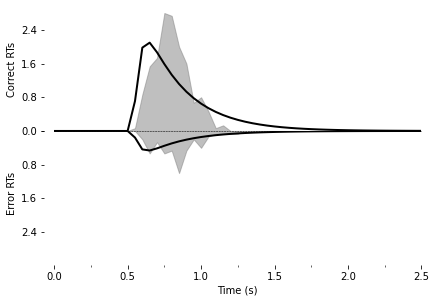

mean decision time 0.799344978165939
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7658862876254181 0.23411371237458195
0.0
True
True
Params [1.41129757 1.30514627 0.83732712 0.53872571] gave 120.99363330576163
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=120.99363330576163, nparams=4, samplesize=299, mess='')
10
correct RTs prob 0.7995624796919693


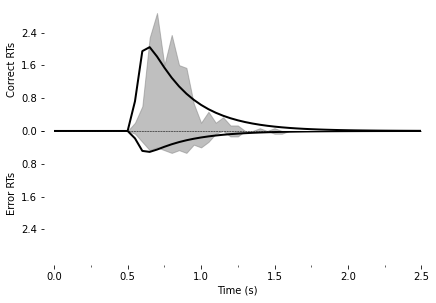

mean decision time 0.909747619047619
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.711864406779661 0.288135593220339
0.0
True
True
Params [0.97038102 1.22060814 0.76582022 0.60576685] gave 207.7643494995777
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=207.7643494995777, nparams=4, samplesize=295, mess='')
12
correct RTs prob 0.7294999588331185


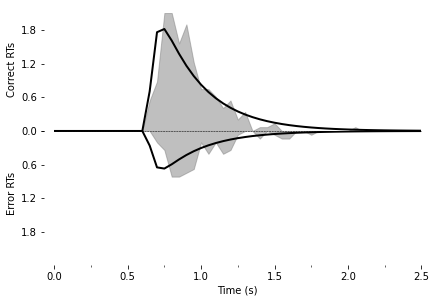

mean decision time 1.0317857142857143
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6148648648648649 0.38513513513513514
0.0
True
True
Params [0.48498543 1.30938799 0.93858841 0.60724834] gave 404.1995011400968
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=404.1995011400968, nparams=4, samplesize=296, mess='')
13
correct RTs prob 0.622627111567084


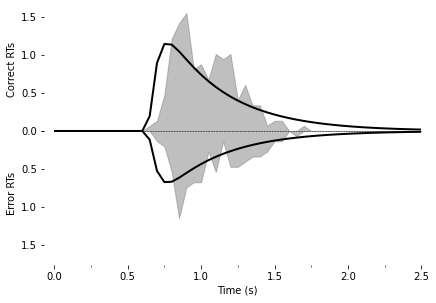

mean decision time 0.8245
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6758620689655173 0.32413793103448274
0.0
True
True
Params [0.77351011 1.22705508 0.83834838 0.4743943 ] gave 275.67171961951715
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=275.67171961951715, nparams=4, samplesize=290, mess='')
14
correct RTs prob 0.7007273757941314


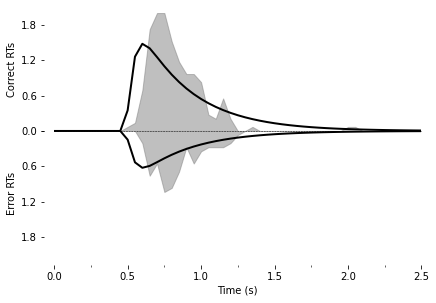

mean decision time 1.6195568181818183
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6518518518518519 0.34814814814814815
0.0
True
True
Params [0.24681376 0.67341434 0.70748273 0.77699694] gave 703.5664172247292
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=703.5664172247292, nparams=4, samplesize=270, mess='')
15
correct RTs prob 0.5758422529956014


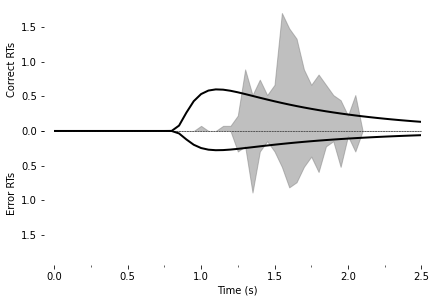

mean decision time 0.9783575129533679
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6454849498327759 0.35451505016722407
0.0
True
True
Params [0.37241948 0.884521   0.73606358 0.43018662] gave 546.4955033880378
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=546.4955033880378, nparams=4, samplesize=299, mess='')
16
correct RTs prob 0.6519317469523686


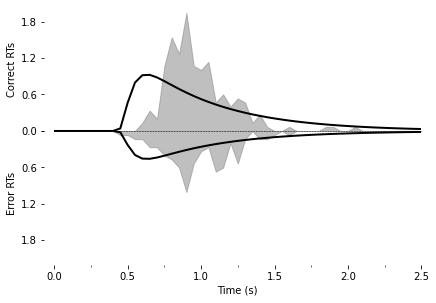

mean decision time 1.4361052631578946
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8 0.2
0.0
True
True
Params [0.73708866 0.96998209 0.99876131 0.67300777] gave 647.839108639066
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=647.839108639066, nparams=4, samplesize=285, mess='')
17
correct RTs prob 0.7538454339876011


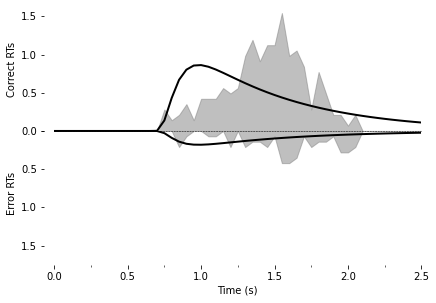

mean decision time 0.9089064039408866
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6789297658862876 0.3210702341137124
0.0
True
True
Params [0.93436474 1.42034055 0.89191795 0.64187159] gave 239.3287335692389
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=239.3287335692389, nparams=4, samplesize=299, mess='')
18
correct RTs prob 0.6943107623500641


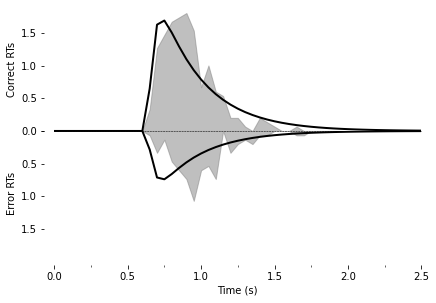

mean decision time 1.0673333333333332
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.673469387755102 0.32653061224489793
0.0
True
True
Params [0.3061336  0.63190508 0.52027725 0.53041627] gave 556.9203647114097
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=556.9203647114097, nparams=4, samplesize=294, mess='')
20
correct RTs prob 0.6715909707356871


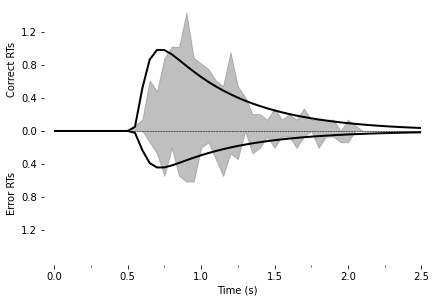

mean decision time 0.9477675438596491
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7625418060200669 0.23745819397993312
0.0
True
True
Params [1.02867845 1.15861383 0.91270649 0.50973864] gave 347.5280004310663
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=347.5280004310663, nparams=4, samplesize=299, mess='')
21
correct RTs prob 0.7929485450056525


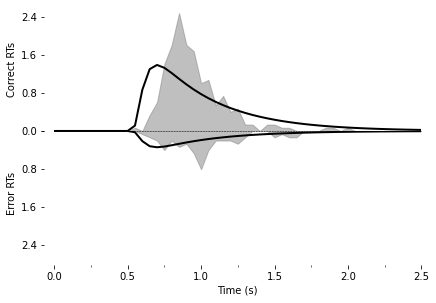

mean decision time 0.7907381974248928
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7792642140468228 0.22073578595317725
0.0
True
True
Params [1.423964   1.27795777 0.88635387 0.46089008] gave 154.78360418097333
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=154.78360418097333, nparams=4, samplesize=299, mess='')
22
correct RTs prob 0.8229637669904304


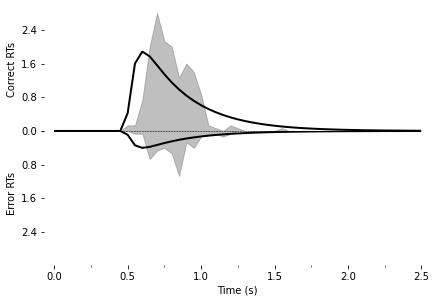

mean decision time 1.0328598130841122
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7508771929824561 0.24912280701754386
0.0
True
True
Params [0.93934821 1.2500757  0.9968258  0.52273334] gave 444.2645132047993
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=444.2645132047993, nparams=4, samplesize=285, mess='')
23
correct RTs prob 0.7566078045657794


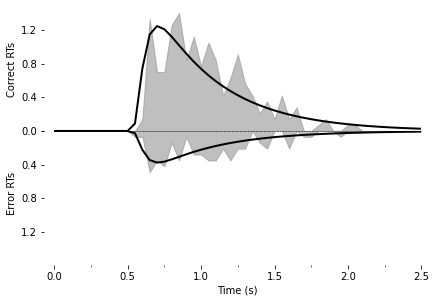

mean decision time 0.9073700440528635
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7643097643097643 0.2356902356902357
0.0
True
True
Params [1.27170698 1.33210776 0.90775447 0.58629371] gave 239.62475584939585
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=239.62475584939585, nparams=4, samplesize=297, mess='')
24
correct RTs prob 0.7841936985107236


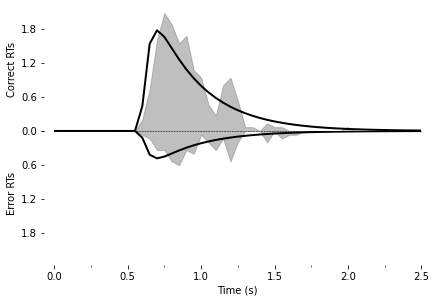

mean decision time 0.8714635193133047
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7818791946308725 0.2181208053691275
0.0
True
True
Params [1.24673892 1.23546141 0.95026734 0.47260353] gave 280.82590788396163
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=280.82590788396163, nparams=4, samplesize=298, mess='')
25
correct RTs prob 0.8196473531498791


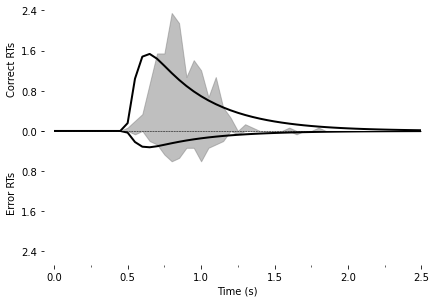

mean decision time 0.8769895833333333
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6464646464646465 0.35353535353535354
0.0
True
True
Params [0.32018414 0.64472616 0.46261092 0.45784965] gave 355.9520644312359
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=355.9520644312359, nparams=4, samplesize=297, mess='')
26
correct RTs prob 0.6662020928674793


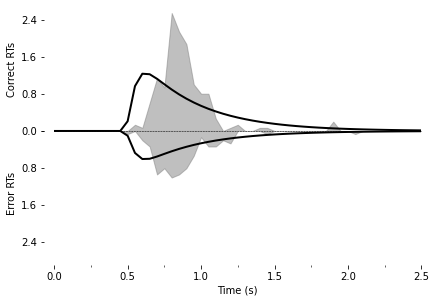

mean decision time 0.9425352112676058
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7123745819397993 0.28762541806020064
0.0
True
True
Params [0.9227811  1.33605112 0.94893929 0.56989298] gave 377.01402826550543
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=377.01402826550543, nparams=4, samplesize=299, mess='')
27
correct RTs prob 0.7225079001456322


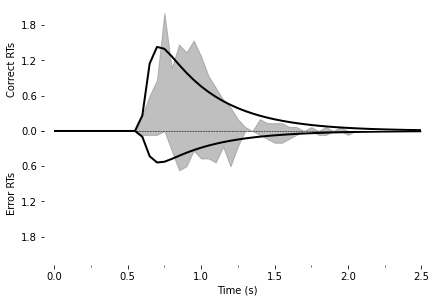

mean decision time 0.7568547486033518
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.608843537414966 0.391156462585034
0.0
True
True
Params [0.38398336 1.10481938 0.79886536 0.30962486] gave 415.4110356972962
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=415.4110356972962, nparams=4, samplesize=294, mess='')
28
correct RTs prob 0.6192354671722857


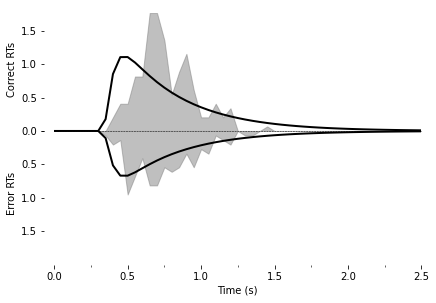

mean decision time 0.8353255813953487
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5850340136054422 0.41496598639455784
0.0
True
True
Params [0.26880476 0.99075842 0.7031932  0.44065588] gave 419.3645332159894
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=419.3645332159894, nparams=4, samplesize=294, mess='')
29
correct RTs prob 0.5911720336401208


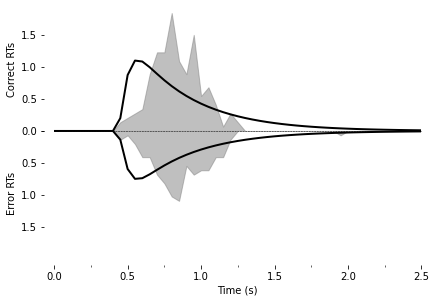

mean decision time 0.8310142180094786
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7152542372881356 0.2847457627118644
0.0
True
True
Params [0.58219385 0.70482505 0.4714923  0.54679721] gave 202.5361502943608
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=202.5361502943608, nparams=4, samplesize=295, mess='')
30
correct RTs prob 0.7497584448135457


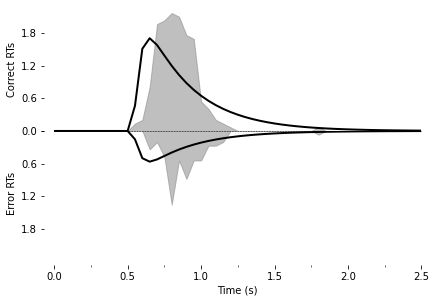

mean decision time 0.8708836206896552
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7811447811447811 0.21885521885521886
0.0
True
True
Params [1.68469312 1.46046618 0.87020787 0.63968361] gave 178.56573201584104
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=178.56573201584104, nparams=4, samplesize=297, mess='')
31
correct RTs prob 0.7977954499002481


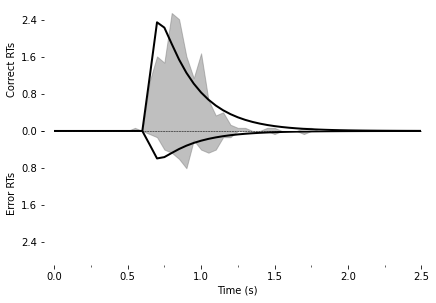

mean decision time 1.5404271844660196
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7686567164179104 0.23134328358208955
0.0
True
True
Params [0.61806459 0.85747889 0.91722503 0.77737694] gave 583.234385072631
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=583.234385072631, nparams=4, samplesize=268, mess='')
32
correct RTs prob 0.7206280300615211


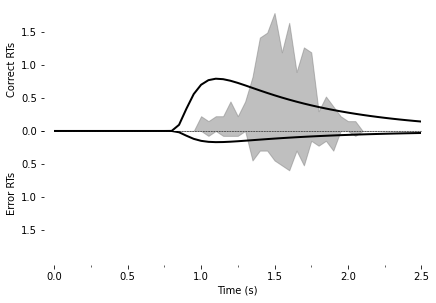

mean decision time 0.9750635593220339
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7892976588628763 0.21070234113712374
0.0
True
True
Params [1.15158916 1.24191936 0.99615786 0.54426328] gave 386.80746360593173
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=386.80746360593173, nparams=4, samplesize=299, mess='')
33
correct RTs prob 0.8058294221327135


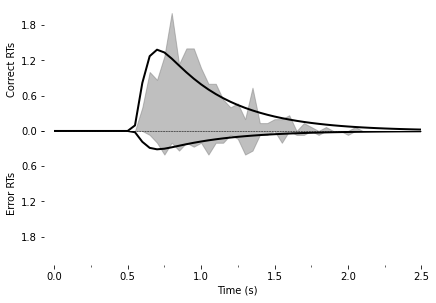

mean decision time 0.904448275862069
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6812080536912751 0.3187919463087248
0.0
True
True
Params [0.91822949 1.38562934 0.93055784 0.57432193] gave 258.5147818546963
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=258.5147818546963, nparams=4, samplesize=298, mess='')
34
correct RTs prob 0.7067472309129813


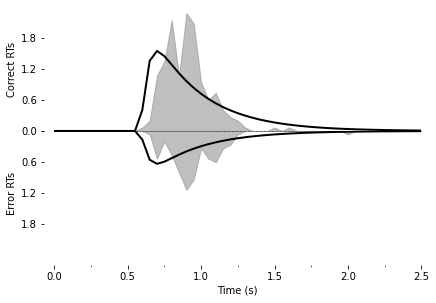

mean decision time 1.0242981651376146
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7315436241610739 0.2684563758389262
0.0
True
True
Params [0.65444291 0.79253213 0.55343104 0.68832626] gave 275.04035971985724
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=275.04035971985724, nparams=4, samplesize=298, mess='')
35
correct RTs prob 0.7555810412704167


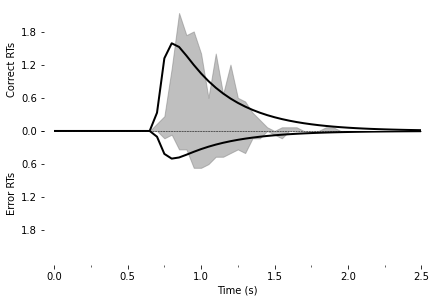

mean decision time 0.9865388601036269
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6498316498316499 0.3501683501683502
0.0
True
True
Params [0.68647582 1.37713723 0.93754114 0.61249959] gave 359.80822701701726
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=359.80822701701726, nparams=4, samplesize=297, mess='')
36
correct RTs prob 0.6597505871142529


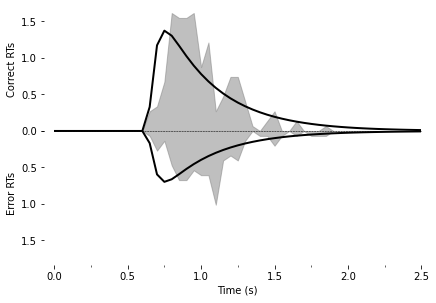

mean decision time 0.8380245098039215
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6845637583892618 0.31543624161073824
0.0
True
True
Params [0.77816475 1.19743057 0.82520934 0.49803191] gave 301.1093339027207
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=301.1093339027207, nparams=4, samplesize=298, mess='')
37
correct RTs prob 0.70754010135181


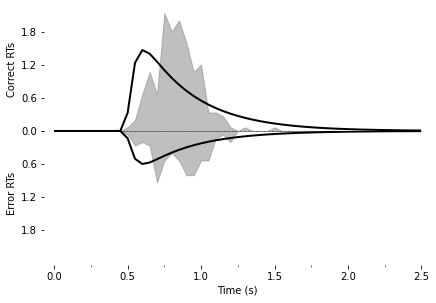

mean decision time 1.3368888888888888
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6678445229681979 0.3321554770318021
0.0
True
True
Params [0.49919675 1.10685622 0.918522   0.78325407] gave 580.9120259940343
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=580.9120259940343, nparams=4, samplesize=283, mess='')
38
correct RTs prob 0.6482006094766862


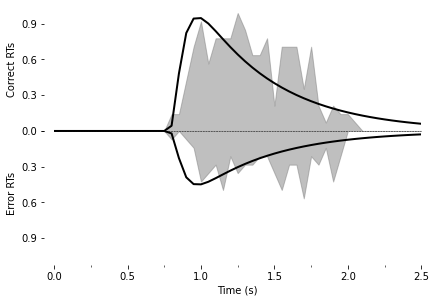

mean decision time 0.9517848101265822
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7926421404682275 0.20735785953177258
0.0
True
True
Params [1.04841379 1.12113176 0.9474667  0.4711939 ] gave 404.388210111967
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=404.388210111967, nparams=4, samplesize=299, mess='')
39
correct RTs prob 0.8164192878644652


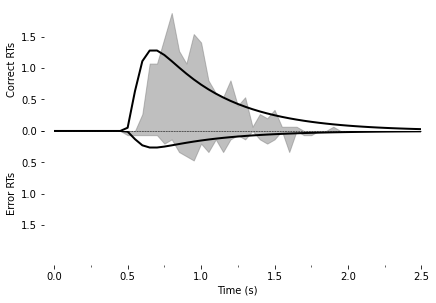

mean decision time 1.0257511961722487
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6989966555183946 0.3010033444816054
0.0
True
True
Params [0.53628139 0.92980275 0.74065303 0.54394483] gave 519.8441640815447
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=519.8441640815447, nparams=4, samplesize=299, mess='')
40
correct RTs prob 0.7015333104308833


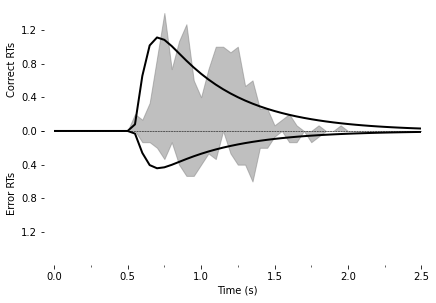

mean decision time 0.9935925925925927
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7248322147651006 0.2751677852348993
0.0
True
True
Params [0.81515672 1.14583057 0.85561034 0.57008918] gave 404.5141428007485
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=404.5141428007485, nparams=4, samplesize=298, mess='')
41
correct RTs prob 0.7353400022012316


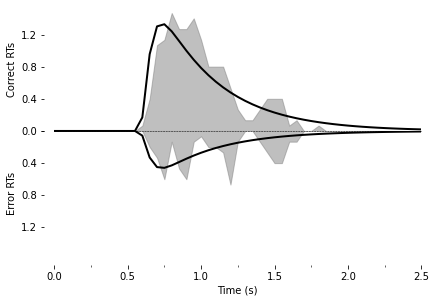

mean decision time 0.6856623376623376
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5167785234899329 0.48322147651006714
0.0
True
True
Params [0.07065424 1.15144201 0.72074068 0.36457763] gave 265.5213263587481
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=265.5213263587481, nparams=4, samplesize=298, mess='')
42
correct RTs prob 0.5187297915146265


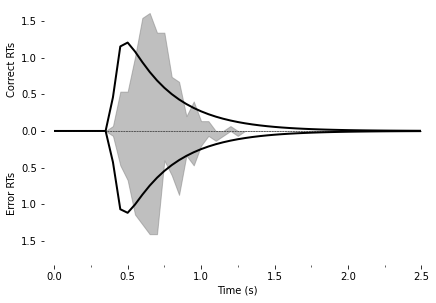

mean decision time 0.9906882591093117
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8288590604026845 0.17114093959731544
0.0
True
True
Params [1.54198064 1.26796173 0.94603656 0.64091475] gave 216.53141795225946
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=216.53141795225946, nparams=4, samplesize=298, mess='')
43
correct RTs prob 0.8554328501154932


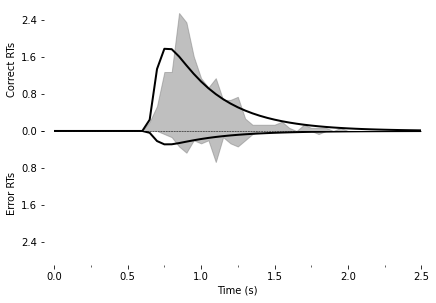

mean decision time 0.9375403225806451
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8294314381270903 0.1705685618729097
0.0
True
True
Params [1.57730448 1.28487085 0.96680005 0.55965576] gave 212.346418290594
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=212.346418290594, nparams=4, samplesize=299, mess='')
44
correct RTs prob 0.8596509398464333


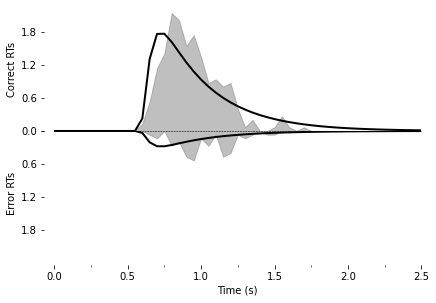

mean decision time 0.8085754189944134
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5986622073578596 0.4013377926421405
0.0
True
True
Params [0.61697844 1.62585097 0.98094249 0.53104886] gave 204.4228009091634
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=204.4228009091634, nparams=4, samplesize=299, mess='')
45
correct RTs prob 0.6119386789465473


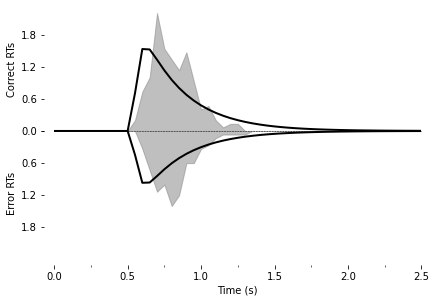

mean decision time 0.8570931677018633
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5669014084507042 0.43309859154929575
0.0
True
True
Params [0.27308971 1.34986046 0.93477986 0.43190765] gave 520.2067939786098
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=520.2067939786098, nparams=4, samplesize=284, mess='')
46
correct RTs prob 0.5667485050979655


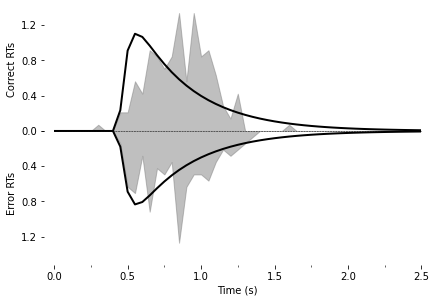

mean decision time 1.0913603603603603
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7424749163879598 0.25752508361204013
0.0
True
True
Params [0.55618875 0.82342527 0.71192157 0.51895964] gave 563.6412416446052
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=563.6412416446052, nparams=4, samplesize=299, mess='')
47
correct RTs prob 0.7402312781929746


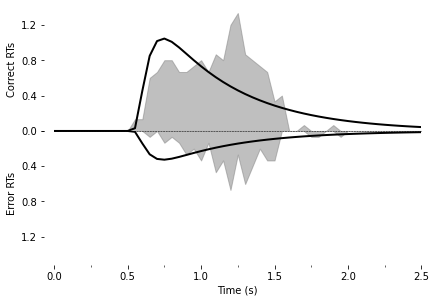

mean decision time 0.9407172774869109
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7100371747211895 0.2899628252788104
0.0
True
True
Params [0.84935763 1.21832565 0.88618812 0.50512452] gave 324.95886639415727
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=324.95886639415727, nparams=4, samplesize=269, mess='')
48
correct RTs prob 0.7283784291918205


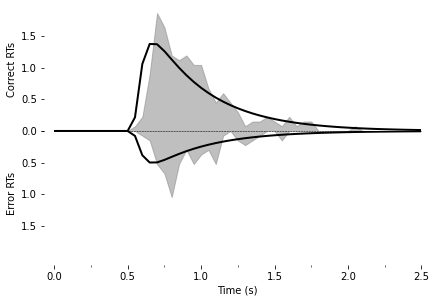

mean decision time 0.78643
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6711409395973155 0.3288590604026846
0.0
True
True
Params [0.87646776 1.42729788 0.9843082  0.43321474] gave 287.52207294031103
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=287.52207294031103, nparams=4, samplesize=298, mess='')
49
correct RTs prob 0.6976526113374255


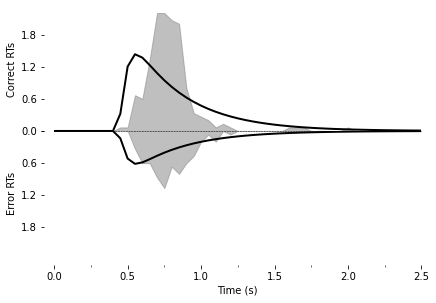

mean decision time 0.8429554655870445
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8316498316498316 0.16835016835016836
0.0
True
True
Params [1.15698087 0.9548346  0.77582321 0.42274824] gave 250.27632540765097
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=250.27632540765097, nparams=4, samplesize=297, mess='')
50
correct RTs prob 0.8721368325950711


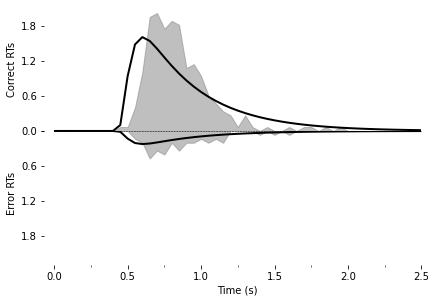

mean decision time 0.9739562841530054
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6224489795918368 0.37755102040816324
0.0
True
True
Params [0.45392747 1.21271574 0.88831053 0.51610785] gave 456.3443930103621
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=456.3443930103621, nparams=4, samplesize=294, mess='')
51
correct RTs prob 0.6268220859381541


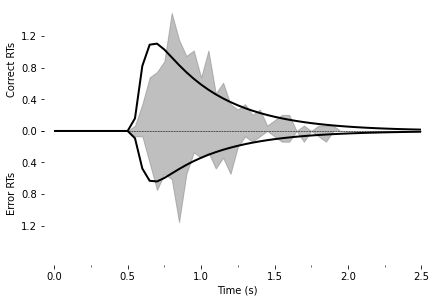

mean decision time 0.8727551867219917
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8060200668896321 0.1939799331103679
0.0
True
True
Params [1.42199565 1.26610202 0.92623965 0.51936457] gave 229.04134096093097
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=229.04134096093097, nparams=4, samplesize=299, mess='')
52
correct RTs prob 0.8346385098054099


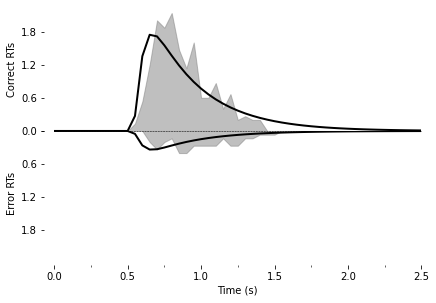

mean decision time 1.00940234375
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8619528619528619 0.13804713804713806
0.0
True
True
Params [1.08384524 0.91883936 0.72945302 0.59576968] gave 331.57631510228833
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=331.57631510228833, nparams=4, samplesize=297, mess='')
53
correct RTs prob 0.8598853419374987


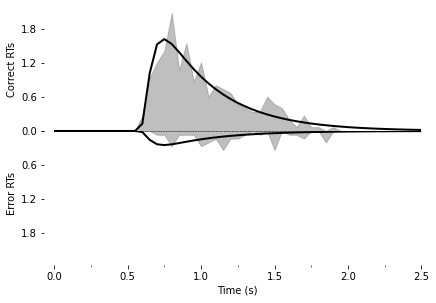

mean decision time 1.1552511848341234
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7326388888888888 0.2673611111111111
0.0
True
True
Params [0.81497593 1.16603222 0.92635596 0.66259471] gave 552.5058284174736
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=552.5058284174736, nparams=4, samplesize=288, mess='')
54
correct RTs prob 0.7358730813129786


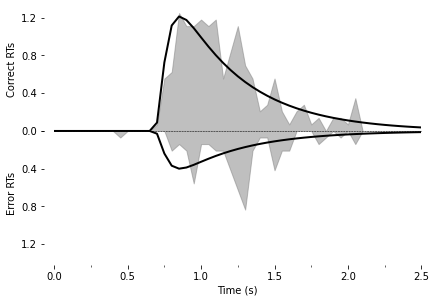

mean decision time 0.7231700000000001
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6688963210702341 0.3311036789297659
0.0
True
True
Params [0.82880763 1.26581041 0.80608638 0.40763917] gave 194.98577209684353
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=194.98577209684353, nparams=4, samplesize=299, mess='')
56
correct RTs prob 0.6965374781636805


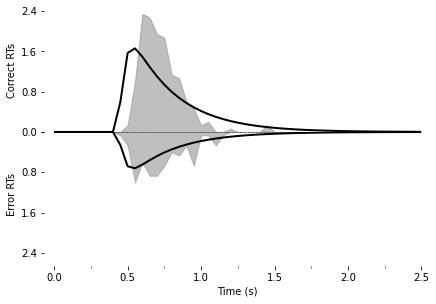

mean decision time 1.2567102040816327
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8193979933110368 0.1806020066889632
0.0
True
True
Params [0.91370842 1.04951698 0.96082897 0.63165086] gave 565.3122240254612
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=565.3122240254612, nparams=4, samplesize=299, mess='')
57
correct RTs prob 0.7992426180923484


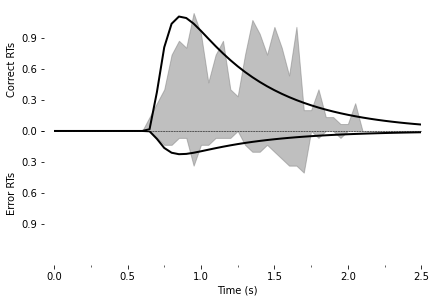

mean decision time 1.5362511013215858
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7881944444444444 0.21180555555555555
0.0
True
True
Params [0.5927128  0.74438677 0.81390891 0.7867078 ] gave 600.5599052452869
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=600.5599052452869, nparams=4, samplesize=288, mess='')
58
correct RTs prob 0.7447675387553109


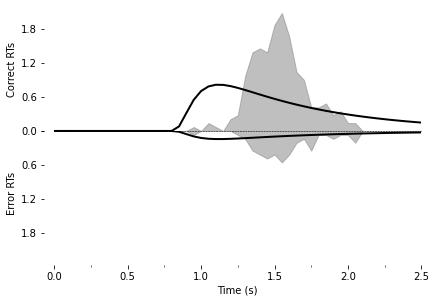

mean decision time 1.0502352941176472
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8013468013468014 0.19865319865319866
0.0
True
True
Params [1.03108776 1.15970208 0.99623857 0.52051698] gave 480.35941806174
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=480.35941806174, nparams=4, samplesize=297, mess='')
59
correct RTs prob 0.8045741642929484


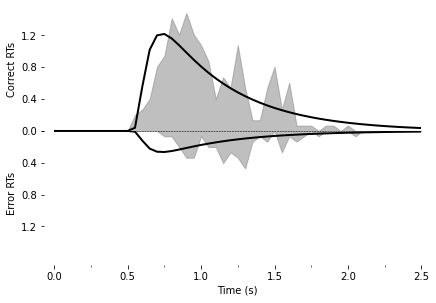

mean decision time 1.056233009708738
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5754189944134078 0.4245810055865922
0.0
True
True
Params [0.1775927  0.84816553 0.70181996 0.45697251] gave 363.733942707358
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=363.733942707358, nparams=4, samplesize=179, mess='')
60
correct RTs prob 0.5685649473504146


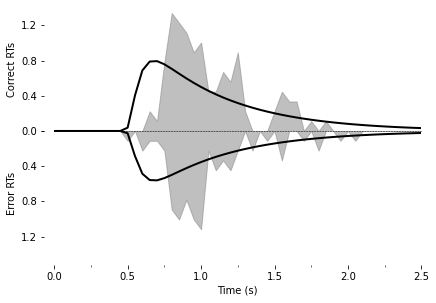

mean decision time 1.2107850877192983
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7676767676767676 0.23232323232323232
0.0
True
True
Params [0.74129798 1.01093648 0.94598111 0.55589959] gave 583.4296575000222
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=583.4296575000222, nparams=4, samplesize=297, mess='')
61
correct RTs prob 0.7590809153154207


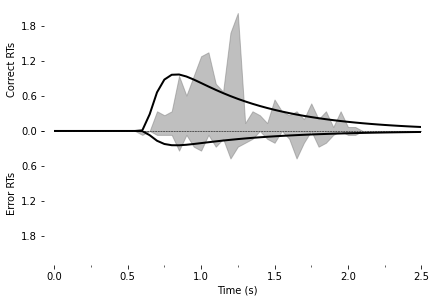

mean decision time 1.4762018779342723
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7344827586206897 0.2655172413793103
0.0
True
True
Params [0.45915643 0.71394822 0.72469064 0.76735064] gave 609.5545042515163
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=609.5545042515163, nparams=4, samplesize=290, mess='')
62
correct RTs prob 0.7005634276764934


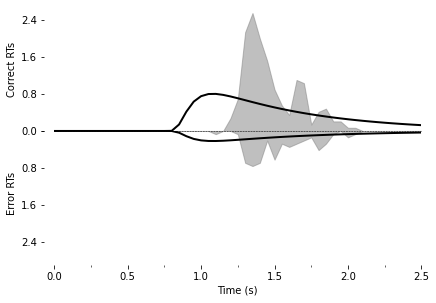

mean decision time 0.8310337078651684
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7478991596638656 0.25210084033613445
0.0
True
True
Params [0.73358525 0.78052022 0.51099974 0.54709159] gave 89.69740318815354
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=89.69740318815354, nparams=4, samplesize=119, mess='')
63
correct RTs prob 0.7729389269117837


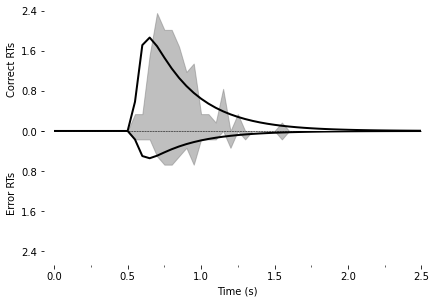

mean decision time 0.8307019230769229
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7027027027027027 0.2972972972972973
0.0
True
True
Params [1.06228541 1.38277115 0.9130165  0.51996639] gave 215.55934737258255
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=215.55934737258255, nparams=4, samplesize=296, mess='')
64
correct RTs prob 0.7325495117997256


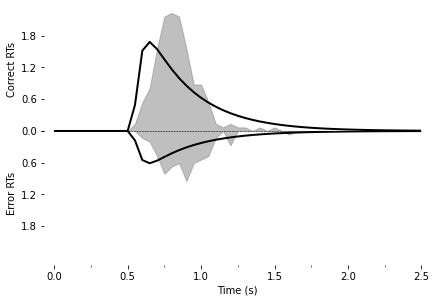

mean decision time 1.4784885844748858
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7423728813559322 0.2576271186440678
0.0
True
True
Params [0.39744795 0.59883679 0.61145919 0.79001457] gave 620.1635859145417
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=620.1635859145417, nparams=4, samplesize=295, mess='')
65
correct RTs prob 0.7075219488829436


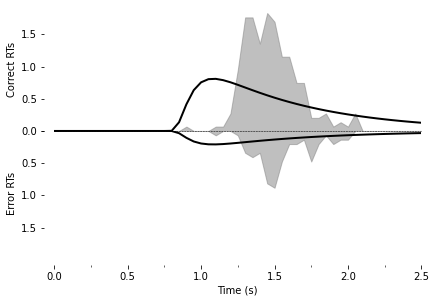

mean decision time 0.9115265957446808
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6372881355932203 0.36271186440677966
0.0
True
True
Params [0.61727139 1.33906551 0.92971763 0.51142975] gave 356.85650028632415
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=356.85650028632415, nparams=4, samplesize=295, mess='')
66
correct RTs prob 0.6510566896369104


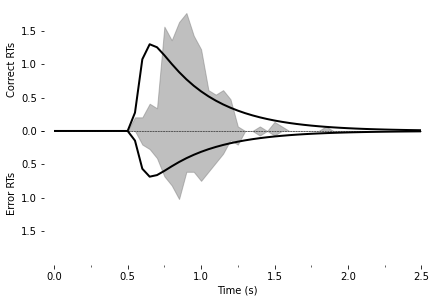

mean decision time 0.9789449152542373
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7892976588628763 0.21070234113712374
0.0
True
True
Params [0.32515968 0.34244025 0.26228918 0.55602876] gave 360.41377652897444
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=360.41377652897444, nparams=4, samplesize=299, mess='')
67
correct RTs prob 0.8032277714639494


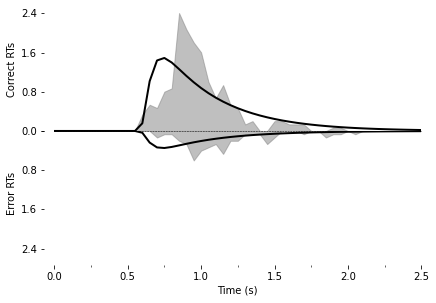

mean decision time 0.803579766536965
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8624161073825504 0.13758389261744966
0.0
True
True
Params [2.13292314 1.39197073 0.96986268 0.51376854] gave 56.59908754926762
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=56.59908754926762, nparams=4, samplesize=298, mess='')
68
correct RTs prob 0.8937087545388889


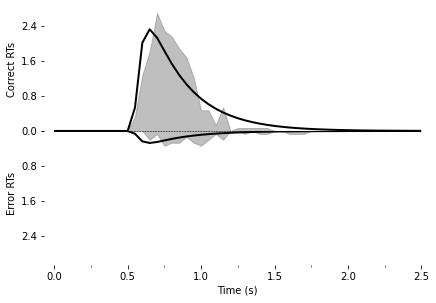

mean decision time 0.7836713615023473
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7171717171717171 0.2828282828282828
0.0
True
True
Params [0.78598096 1.03584715 0.7341915  0.4231647 ] gave 301.16781526861155
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=301.16781526861155, nparams=4, samplesize=297, mess='')
69
correct RTs prob 0.7427133491705008


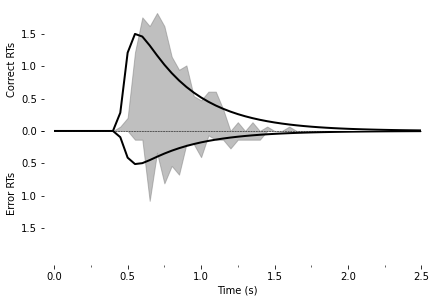

mean decision time 1.121524017467249
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7658862876254181 0.23411371237458195
0.0
True
True
Params [0.68145635 0.91207007 0.78860349 0.57318709] gave 542.1870907648675
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=542.1870907648675, nparams=4, samplesize=299, mess='')
71
correct RTs prob 0.7612763254212235


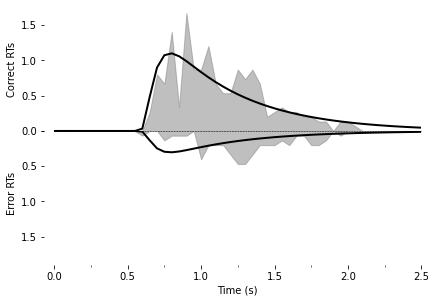

mean decision time 1.2108056680161945
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8546712802768166 0.1453287197231834
0.0
True
True
Params [0.56239444 0.55702534 0.50520484 0.61217661] gave 491.5705370721423
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=491.5705370721423, nparams=4, samplesize=289, mess='')
72
correct RTs prob 0.8369927028809765


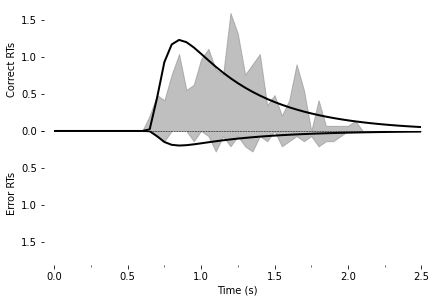

mean decision time 1.0315326633165829
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7107142857142857 0.2892857142857143
0.0
True
True
Params [0.66962725 1.13630349 0.94684205 0.4797303 ] gave 521.694986608895
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=521.694986608895, nparams=4, samplesize=280, mess='')
74
correct RTs prob 0.7106938524242117


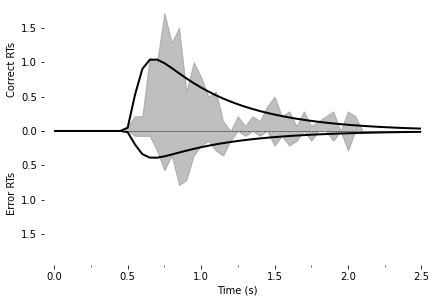

mean decision time 0.8163333333333335
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5896551724137931 0.4103448275862069
0.0
True
True
Params [0.46371096 1.49475291 0.9716214  0.48314745] gave 311.2230129983827
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=311.2230129983827, nparams=4, samplesize=290, mess='')
75
correct RTs prob 0.5982892164154807


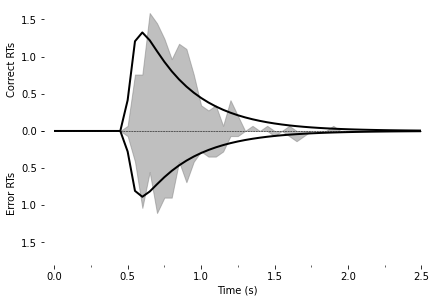

mean decision time 1.534679012345679
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.574468085106383 0.425531914893617
0.0
True
True
Params [0.13259124 0.81043385 0.85694996 0.62951411] gave 836.4461695762258
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=836.4461695762258, nparams=4, samplesize=282, mess='')
76
correct RTs prob 0.49854806486711656


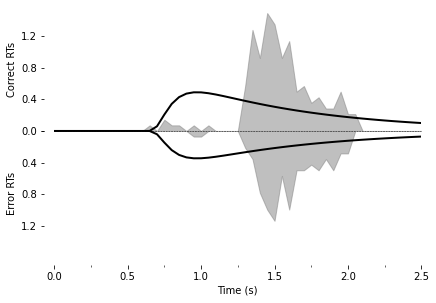

mean decision time 0.7737248322147651
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5102739726027398 0.4897260273972603
0.0
True
True
Params [0.01554964 0.54026593 0.43694491 0.22480013] gave 577.0225832403579
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=577.0225832403579, nparams=4, samplesize=292, mess='')
77
correct RTs prob 0.5033138516910352


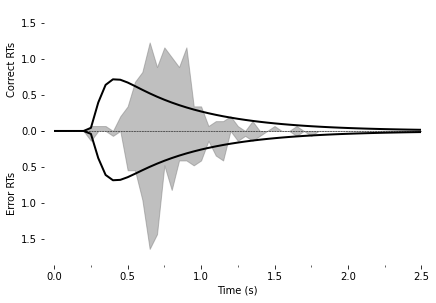

mean decision time 0.9045792079207919
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7062937062937062 0.2937062937062937
0.0
True
True
Params [0.91953984 1.32612369 0.96902354 0.5367815 ] gave 336.4442032788841
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=336.4442032788841, nparams=4, samplesize=286, mess='')
78
correct RTs prob 0.7279392529559018


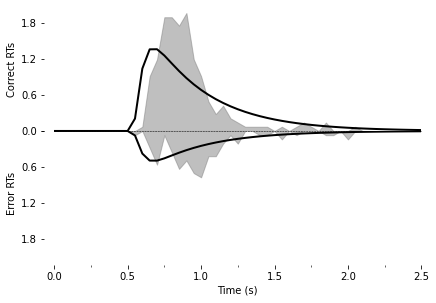

mean decision time 0.8323218390804599
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5938566552901023 0.4061433447098976
0.0
True
True
Params [0.34465998 1.11690477 0.78927136 0.40143263] gave 383.5626055494908
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=383.5626055494908, nparams=4, samplesize=293, mess='')
79
correct RTs prob 0.6036024714492644


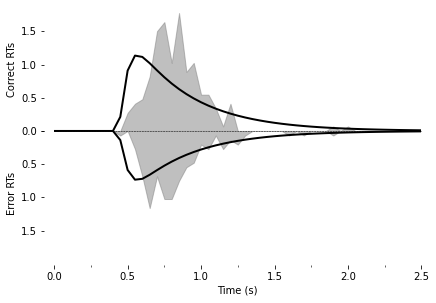

mean decision time 1.3758480392156862
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7338129496402878 0.26618705035971224
0.0
True
True
Params [0.16849419 0.32541206 0.33387721 0.49114566] gave 767.7771969389955
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=767.7771969389955, nparams=4, samplesize=278, mess='')
80
correct RTs prob 0.6785342302379749


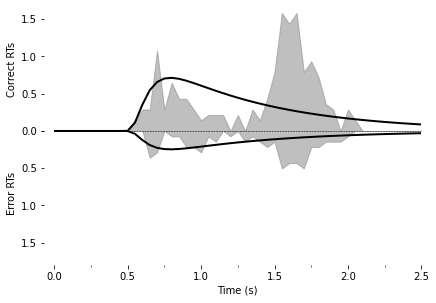

mean decision time 1.2102620320855615
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6470588235294118 0.35294117647058826
0.0
True
True
Params [0.35321686 0.93356304 0.77437604 0.63525642] gave 636.6570718038577
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=636.6570718038577, nparams=4, samplesize=289, mess='')
81
correct RTs prob 0.6285896023752545


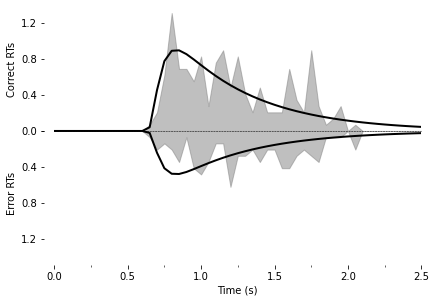

mean decision time 0.8583131313131311
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.668918918918919 0.3310810810810811
0.0
True
True
Params [0.65529807 0.97341347 0.60017223 0.57290643] gave 161.0864192985875
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=161.0864192985875, nparams=4, samplesize=296, mess='')
82
correct RTs prob 0.6955798141297651


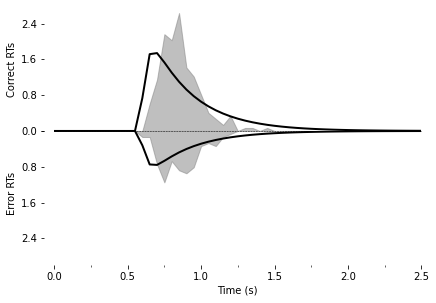

mean decision time 0.7293076923076924
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7391304347826086 0.2608695652173913
0.0
True
True
Params [1.02418138 1.10810989 0.75388521 0.42958082] gave 188.2159595020397
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=188.2159595020397, nparams=4, samplesize=299, mess='')
83
correct RTs prob 0.7775935623365943


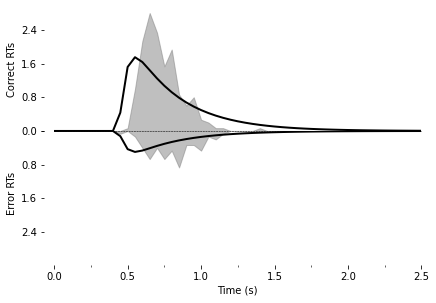

mean decision time 1.6447794871794874
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6989247311827957 0.3010752688172043
0.0
True
True
Params [0.35961769 0.83526965 0.93516787 0.64131848] gave 830.1038821168252
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=830.1038821168252, nparams=4, samplesize=279, mess='')
84
correct RTs prob 0.6054262072716291


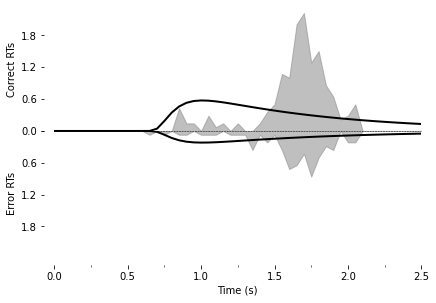

mean decision time 0.9088142857142857
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7023411371237458 0.2976588628762542
0.0
True
True
Params [0.90692407 1.21021086 0.82635707 0.5699052 ] gave 247.35678088641492
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=247.35678088641492, nparams=4, samplesize=299, mess='')
85
correct RTs prob 0.7329897294532625


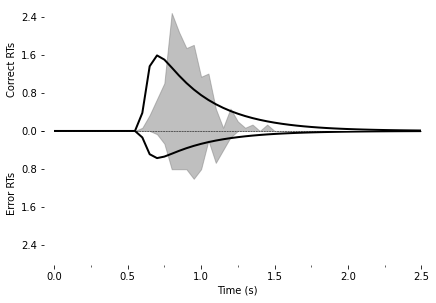

mean decision time 0.8104184782608697
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6195286195286195 0.38047138047138046
0.0
True
True
Params [0.40760362 0.95579135 0.63320003 0.47247704] gave 289.4381607569308
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=289.4381607569308, nparams=4, samplesize=297, mess='')
86
correct RTs prob 0.6361735245085749


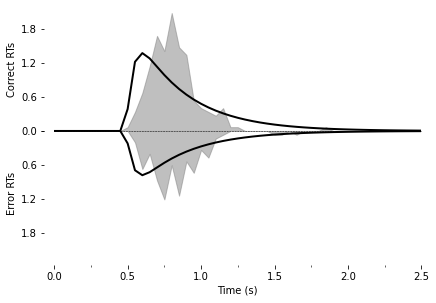

mean decision time 0.8601179487179488
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6543624161073825 0.34563758389261745
0.0
True
True
Params [0.82914742 1.43795493 0.87079841 0.55787355] gave 308.2152941426497
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=308.2152941426497, nparams=4, samplesize=298, mess='')
87
correct RTs prob 0.6671402493087069


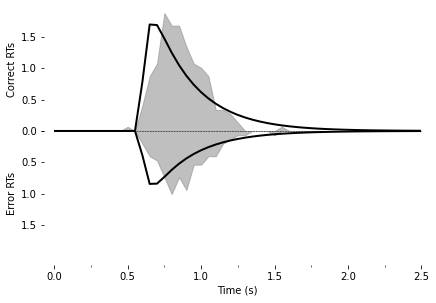

mean decision time 0.8465714285714286
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7380952380952381 0.2619047619047619
0.0
True
True
Params [1.03740465 1.23921265 0.85882243 0.50448255] gave 279.34460984629
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=279.34460984629, nparams=4, samplesize=294, mess='')
88
correct RTs prob 0.7588322706981669


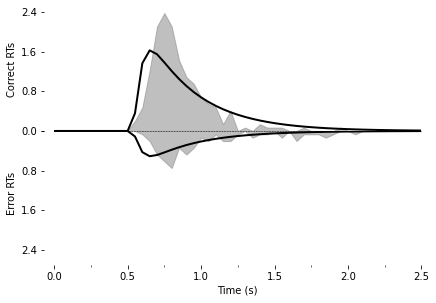

mean decision time 0.8864385964912281
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5719063545150501 0.4280936454849498
0.0
True
True
Params [0.38609838 1.3249841  0.76680201 0.61904974] gave 156.5892466888523
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=156.5892466888523, nparams=4, samplesize=299, mess='')
89
correct RTs prob 0.5830225195769341


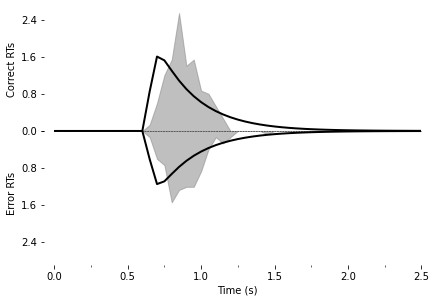

mean decision time 0.8612926829268293
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6879194630872483 0.31208053691275167
0.0
True
True
Params [0.73849697 1.21961297 0.93144699 0.41777739] gave 497.9462396878061
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=497.9462396878061, nparams=4, samplesize=298, mess='')
90
correct RTs prob 0.7086300816391444


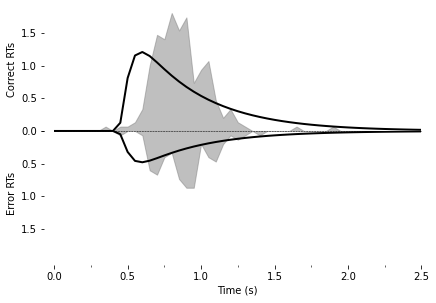

mean decision time 0.8624159292035398
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7558528428093646 0.24414715719063546
0.0
True
True
Params [1.19846989 1.24998311 0.87417811 0.51899088] gave 223.0254329283795
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=223.0254329283795, nparams=4, samplesize=299, mess='')
91
correct RTs prob 0.7902062014206235


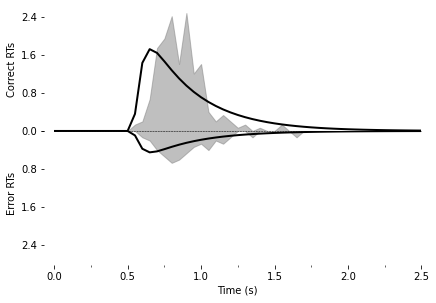

mean decision time 0.7130893854748603
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5986622073578596 0.4013377926421405
0.0
True
True
Params [0.43250405 1.19801931 0.77935527 0.39136792] gave 268.4315726870956
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=268.4315726870956, nparams=4, samplesize=299, mess='')
92
correct RTs prob 0.6145353968285033


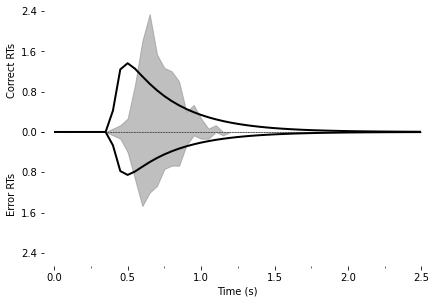

mean decision time 1.624565789473684
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8636363636363636 0.13636363636363635
0.0
True
True
Params [0.79009208 0.74361551 0.96457072 0.78710651] gave 525.2366129240697
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=525.2366129240697, nparams=4, samplesize=264, mess='')
93
correct RTs prob 0.7976900276135905


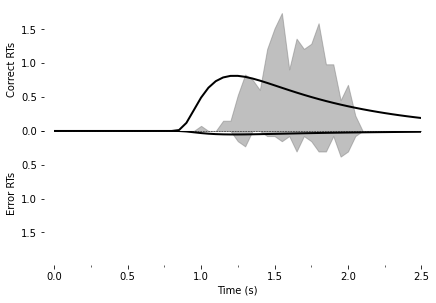

mean decision time 0.9701330275229358
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7315436241610739 0.2684563758389262
0.0
True
True
Params [0.60316154 0.76486903 0.54983856 0.57391496] gave 326.8025658733092
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=326.8025658733092, nparams=4, samplesize=298, mess='')
94
correct RTs prob 0.7515252496740478


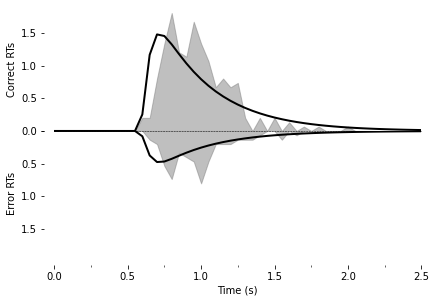

mean decision time 1.4308341013824883
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7722419928825622 0.2277580071174377
0.0
True
True
Params [0.49548552 0.76999428 0.86029888 0.51412955] gave 739.8974424465981
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=739.8974424465981, nparams=4, samplesize=281, mess='')
95
correct RTs prob 0.712158832661579


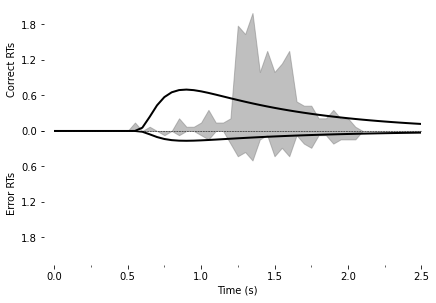

mean decision time 0.9961416309012876
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7818791946308725 0.2181208053691275
0.0
True
True
Params [1.18813061 1.16724847 0.85927297 0.63970153] gave 260.24346735320495
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=260.24346735320495, nparams=4, samplesize=298, mess='')
96
correct RTs prob 0.8119367251891051


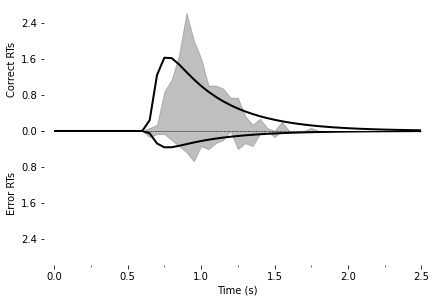

mean decision time 0.9069798994974876
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6677852348993288 0.33221476510067116
0.0
True
True
Params [0.60731501 1.12904234 0.82017885 0.49928181] gave 403.81939739816215
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=403.81939739816215, nparams=4, samplesize=298, mess='')
97
correct RTs prob 0.6806490305198434


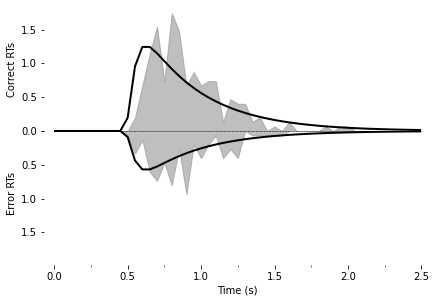

mean decision time 0.7558691099476439
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.6409395973154363 0.35906040268456374
0.0
True
True
Params [0.42337958 0.77429473 0.47187331 0.47985276] gave 191.53069553652801
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=191.53069553652801, nparams=4, samplesize=298, mess='')
98
correct RTs prob 0.6602117653233158


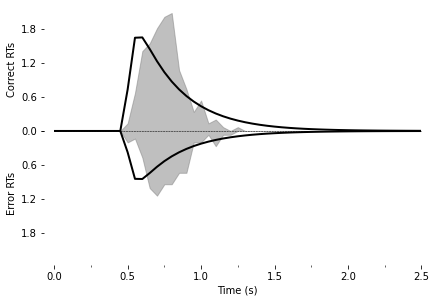

mean decision time 0.7929329608938549
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5986622073578596 0.4013377926421405
0.0
True
True
Params [0.37226132 1.1164792  0.72182554 0.45282417] gave 277.5913624887009
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=277.5913624887009, nparams=4, samplesize=299, mess='')
99
correct RTs prob 0.6050245627608063


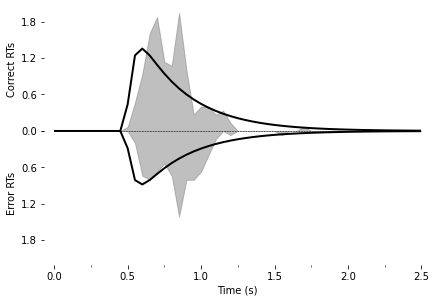

mean decision time 0.8698636363636364
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5945945945945946 0.40540540540540543
0.0
True
True
Params [0.53778302 1.51340812 0.92480114 0.57592124] gave 228.31110314422702
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=228.31110314422702, nparams=4, samplesize=296, mess='')
100
correct RTs prob 0.6060528663456931


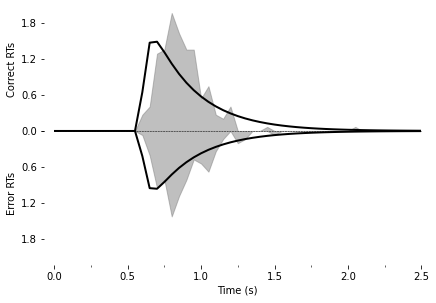

mean decision time 0.8358823529411764
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5704697986577181 0.42953020134228187
0.0
True
True
Params [0.13683204 0.6144949  0.42101978 0.46078849] gave 495.87806659946614
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=495.87806659946614, nparams=4, samplesize=298, mess='')
101
correct RTs prob 0.5728928833261233


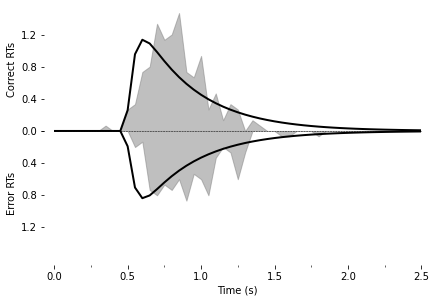

In [9]:
#import ddm.plot
from ddm.models import BoundCollapsingExponential
from ddm.models import ICRange
subjects = []
drift = []
noise = []
boundary = []
nondectime = []
fit = []
loss = []

#fig, axes = plt.subplots(nrows=16, ncols=5, figsize = (70,50))
#fig.subplots_adjust(hspace=0.5)
#fig.suptitle('PyDDM Fits YA', fontsize=20)


#for ax, name in zip(axes.flatten(), SubjectList):
 #   print(name)
    
for sub in SubjectList:
   
    sub_df = data[data['subj_idx'] == sub]

   # Load Data
    sample = Sample.from_pandas_dataframe(sub_df, rt_column_name="rt", correct_column_name="accuracy")
    print("mean decision time", sample.mean_decision_time())
   # print(sample.condition_combinations())
    print(sample.condition_names())
    print(sample.prob_correct(), sample.prob_error())
    print(sample.prob_undecided())
   # print(sample.corr) # RT for correct trials
   # plt.plot(sample.corr)
   # plt.plot(sample.err)
   # plt.show()
   
    #print("correct + error component of the joint CDF")
   # plt.plot(sample.cdf_corr())
   # plt.plot(sample.cdf_err())
   # plt.show()
    
    
 
    # Set up and fit ddm model
    simple_model = setup_model()
    print(simple_model.has_analytical_solution()) #False if collapsing bounds, can't apply solve function to this model then
    print(simple_model.can_solve_cn()) # False if collapsing bounds, solving numerically with Crank-Nicolson won't work then
    
    
    fit_model = fit_adjust_model(sample=sample, model=simple_model, lossfunction=LossRobustBIC, verbose=False)
    print("Fitted", fit_model.get_fit_result())

    print(sub)
    subjects.append(np.unique(sub_df['subj_idx'])[0])
    drift.append(float(simple_model.get_model_parameters()[0]))
    noise.append(float(simple_model.get_model_parameters()[1])) 
    boundary.append(float(simple_model.get_model_parameters()[2]))
    nondectime.append(float(simple_model.get_model_parameters()[3]))
    fit.append(simple_model.fitresult.value())
    loss.append(simple_model.fitresult.loss)
    s = fit_model.solve()
    print("correct RTs prob", s.prob_correct()) #float
   

    ddm.plot.plot_fit_diagnostics(model=fit_model, sample=sample)
    plt.savefig('ddm_test1_eyemem1_sub_{}.png'.format(sub))
    plt.show()
    plt.close()
   # display_model(fit_model)
   # if all(sub_df['age']==0):
       # ddm.plot.plot_fit_diagnostics(model=fit_model, sample=sample)
        #plt.show()
       # ddm.plot.model_gui_jupyter(model=fit_model, sample=sample)

   
        
    
fit_dict= {'subjects': subjects, 'drift': drift, 'noise': noise, 'boundary': boundary, 'nondec': nondectime, 'fit': fit, 'loss': loss} 
fit_df = pd.DataFrame(fit_dict)

    

In [10]:
fit_df.to_pickle('fitted_pyddm_test_2') 
fit_df

,subjects,drift,noise,boundary,nondec,fit,loss
0,9,1.346097,1.156946,0.749889,0.548658,87.524510,BIC
1,10,1.411298,1.305146,0.837327,0.538726,120.993633,BIC
2,12,0.970381,1.220608,0.765820,0.605767,207.764349,BIC
3,13,0.484985,1.309388,0.938588,0.607248,404.199501,BIC
4,14,0.773510,1.227055,0.838348,0.474394,275.671720,BIC
...,...,...,...,...,...,...,...
83,97,0.607315,1.129042,0.820179,0.499282,403.819397,BIC
84,98,0.423380,0.774295,0.471873,0.479853,191.530696,BIC
85,99,0.372261,1.116479,0.721826,0.452824,277.591362,BIC
86,100,0.537783,1.513408,0.924801,0.575921,228.311103,BIC


In [14]:
fit_1 = pd.read_pickle('fitted_pyddm_test_1')
fit_2 = pd.read_pickle('fitted_pyddm_test_2')

Drift: 0.8206603507729249


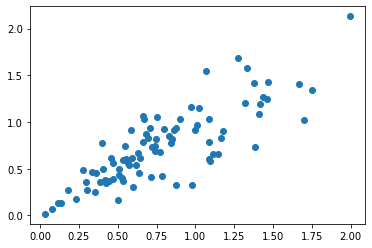

In [18]:
print("Drift:", fit_1['drift'].corr(fit_2['drift']))
plt.scatter(fit_1['drift'], fit_2['drift'])
plt.show()

Noise: 0.3172276702805213


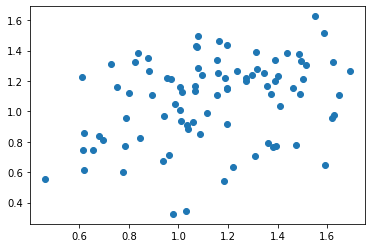

In [19]:
print("Noise:", fit_1['noise'].corr(fit_2['noise']))
plt.scatter(fit_1['noise'], fit_2['noise'])
plt.show()

Boundary: -0.1398914443994795


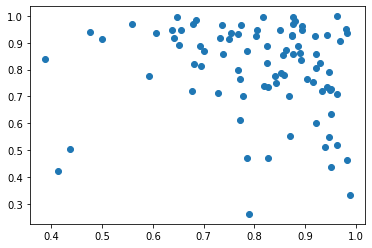

In [20]:
print("Boundary:", fit_1['boundary'].corr(fit_2['boundary']))
plt.scatter(fit_1['boundary'], fit_2['boundary'])
plt.show()

Non-descision time: 0.9683036066810813


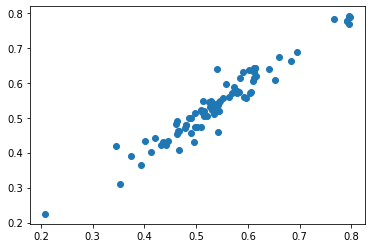

In [21]:
print("Non-descision time:", fit_1['nondec'].corr(fit_2['nondec']))
plt.scatter(fit_1['nondec'], fit_2['nondec'])
plt.show()

Fit: 0.9952598575033487


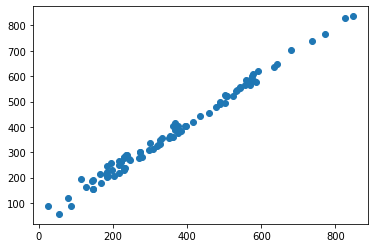

In [22]:
print("Fit:", fit_1['fit'].corr(fit_2['fit']))
plt.scatter(fit_1['fit'], fit_2['fit'])
plt.show()

In [ ]:
    
    def fit_group_ddm(self, cpus):
        """
        Fits a separate ddm to all subjects and colors. 
        Saves fitting results to result file.
        """
        # Computes fitting for each category in parallel
        with Pool(processes=cpus) as p: 
            white_results = p.starmap(self.fit_single_ddm, zip(self.SubjectList,['white']*len(self.SubjectList)))
            blue_results = p.starmap(self.fit_single_ddm, zip(self.SubjectList,['blue']*len(self.SubjectList)))
            pink_results = p.starmap(self.fit_single_ddm, zip(self.SubjectList,['pink']*len(self.SubjectList)))
        
        # Put results into one DataFrame
        results_list = []
        for results, color in zip([white_results, blue_results, pink_results], self.noisecolors):
            results = pd.DataFrame(results)
            results['noise_color'] = color
            results['ID'] = self.SubjectList
            results_list.append(results)
        results_df = pd.concat(results_list)
        # Save to File
        results_df.to_csv(self.resultfile)

In [ ]:
# Create a sample object from our data.  This is the standard input
# format for fitting procedures.  Since RT and correct/error are
# both mandatory columns, their names are specified by command line
# arguments.
test_sample = Sample.from_pandas_dataframe(df_rt, rt_column_name="rt", correct_column_name="accuracy")

In [ ]:

#drift rate vary with the stim (ie if target present or not) as drift represents evidence and this differes dependent on stim
#how do we include age or category?
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    required_parameters = ["driftcoh"] # <-- Parameters we want to include in the model
    required_conditions = ["stim"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.
    
    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.driftcoh * conditions['stim']


In [ ]:

model_rs = Model(name='test data, drift varies with stim',
                 drift=DriftCoherence(driftcoh=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                 # Since we can only have one overlay, we use
                 # OverlayChain to string together multiple overlays.
                 # They are applied sequentially in order.  OverlayNonDecision
                 # implements a non-decision time by shifting the
                 # resulting distribution of response times by
                 # `nondectime` seconds.
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.001, dt=.01, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_rs = fit_adjust_model(sample=test_sample, model=model_rs, verbose=False)


In [ ]:
display_model(fit_model_rs)

In [ ]:
import ddm.plot
import matplotlib.pyplot as plt
ddm.plot.plot_fit_diagnostics(model=fit_model_rs, sample=test_sample)
#plt.savefig("roitman-fit.png")
plt.show()


In [ ]:
df

In [ ]:
# compute T_dur:
T_dur = df['rt'].max()+1
T_dur 

In [ ]:
pwd

In [ ]:

m = Model()
s = m.solve()
plt.plot(s.model.t_domain(), s.pdf_corr())
#plt.savefig("helloworld.png")
plt.show()


In [ ]:

model = Model(name='Simple model',
              drift=DriftConstant(drift=2.2),
              noise=NoiseConstant(noise=1.5),
              bound=BoundConstant(B=1.1),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2)
display_model(model)
sol = model.solve()

In [ ]:
#generate psuedo-data from this solved model with the resample() function
samp = sol.resample(1000)

In [ ]:

model_fit = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=1.1),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=2)

fit_adjust_model(samp, model_fit,
                 fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC, verbose=False)

In [ ]:
display_model(model_fit)

In [ ]:
import ddm.plot
ddm.plot.plot_fit_diagnostics(model=model_fit, sample=samp)
#plt.savefig("simple-fit.png")
plt.show()



In [ ]:
print(sol.prob_correct())
print(sol.pdf_err())